In [ ]:
%pip install tensorflow keras numpy pandas matplotlib scikit-learn keras-tuner building_footprint_segmentation

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


GPUs Available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

Training model with combined training data:
Classes in '/content/drive/MyDrive/RA Satellite Imagery Work/Abduls RA Work Folder/SAT_Images/Phase 2': ['Hospital', 'High', 'Commercial', 'Schools', 'Single', 'Industrial', 'Multi']
Combined Classes from Training Directories: ['Commercial', 'High', 'Hospital', 'Industrial', 'Multi', 'Schools', 'Single']
Total duplicates found and removed: 0
Balancing classes to have 201 images each.
Training with classes: ['Commercial', 'High', 'Hospital', 'Industrial', 'Multi', 'Schools', 'Single']
Total images collected: 1407
Training images: 1125
Temp images (for validation and testing): 282
Validation images: 141
Test images: 141

Dataset: Training set
Class: Commercial, Number of images: 161
Class: High, Number of images: 161
Class: Hospital, Number of images: 161
Class: Industrial, Number of images: 160
Class: Multi, Number of images: 161
Class: Schools, Number of image

Model saved at /content/drive/MyDrive/Densenet201_combined_newdata.h5.


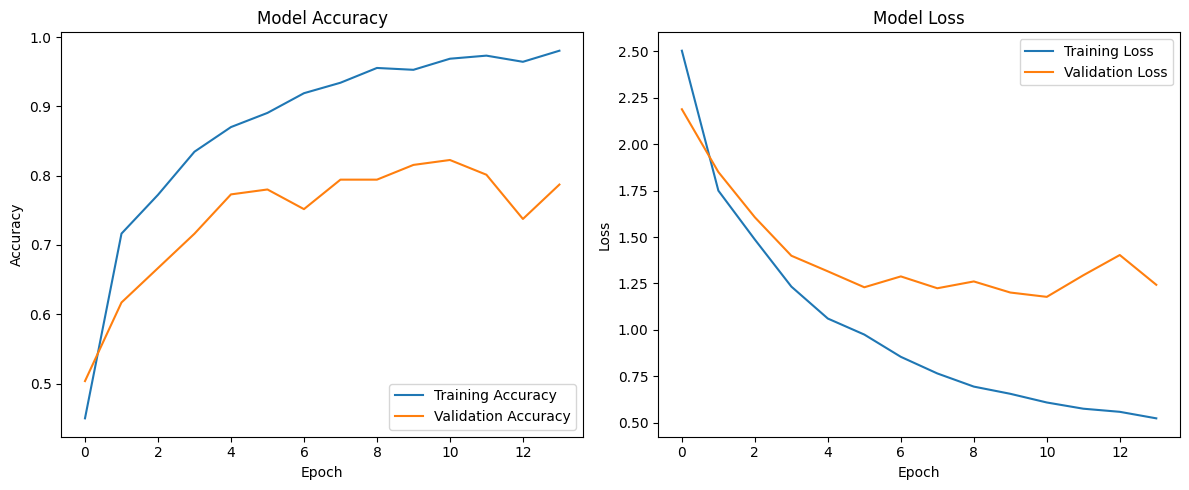

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 243ms/step - accuracy: 0.8108 - loss: 0.9860
Test Accuracy: 84.3972%
5/5 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step
Confusion Matrix:
 [[12  1  0  2  4  1  0]
 [ 1 18  0  1  0  0  0]
 [ 0  0 16  1  0  3  0]
 [ 0  0  0 20  0  1  0]
 [ 1  0  1  0 17  0  1]
 [ 1  0  1  0  1 17  0]
 [ 0  0  1  0  0  0 19]]
Classification Report:
               precision    recall  f1-score   support

  Commercial       0.80      0.60      0.69        20
        High       0.95      0.90      0.92        20
    Hospital       0.84      0.80      0.82        20
  Industrial       0.83      0.95      0.89        21
       Multi       0.77      0.85      0.81        20
     Schools       0.77      0.85      0.81        20
      Single       0.95      0.95      0.95        20

    accuracy                           0.84       141
   macro avg       0.85      0.84      0.84       141
weighted avg       0.85      0.84      0.84       141


Final Test Accuracy: 84.3972%


In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import matplotlib.pyplot as plt
import logging
import hashlib
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split  # Added for data splitting


from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')


# Set seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Configure logging
logging.basicConfig(
    filename='model_training.log',
    level=logging.INFO,
    format='%(asctime)s:%(levelname)s:%(message)s'
)

# Verify GPU availability
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs Available:", gpus)
    logging.info(f"GPUs Available: {gpus}")
else:
    print("No GPU found. Please ensure that TensorFlow is configured properly.")
    logging.warning("No GPU found. Using CPU for training.")

# Set the image size and batch size
img_size = (512, 512)
batch_size = 32

# Set the base directories for the data
existing_train_dir = '/content/drive/MyDrive/Madhu RA Work Folder/newdata'
new_data_dir = '/content/drive/MyDrive/RA Satellite Imagery Work/Abduls RA Work Folder/SAT_Images/Phase 2'

# Function to get class names from training directories
def get_class_names(directories):
    class_names = set()
    for directory in directories:
        if not os.path.isdir(directory):
            logging.warning(f"Directory '{directory}' does not exist. Skipping.")
            continue
        classes_in_dir = [item for item in os.listdir(directory) if os.path.isdir(os.path.join(directory, item))]
        print(f"Classes in '{directory}': {classes_in_dir}")
        logging.info(f"Classes in '{directory}': {classes_in_dir}")
        class_names.update(classes_in_dir)
    class_names = sorted(list(class_names))
    print("Combined Classes from Training Directories:", class_names)
    logging.info(f"Combined Classes from Training Directories: {class_names}")
    return class_names

# Function to collect data paths from multiple directories
def collect_data_paths(data_directories, class_names):
    image_paths = []
    labels = []
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}
    image_hashes = set()
    duplicate_count = 0

    for data_directory in data_directories:
        if not os.path.isdir(data_directory):
            logging.warning(f"Data directory '{data_directory}' does not exist. Skipping.")
            continue
        for class_name in class_names:
            folder_path = os.path.join(data_directory, class_name)
            if not os.path.isdir(folder_path):
                logging.warning(f"Class directory '{folder_path}' does not exist in '{data_directory}'. Skipping.")
                continue
            for img_file in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_file)
                if img_file.lower().endswith(('.tif', '.tiff', '.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                    try:
                        # Compute hash of the image
                        with open(img_path, 'rb') as f:
                            img_hash = hashlib.md5(f.read()).hexdigest()
                        # Check if the image is a duplicate
                        if img_hash in image_hashes:
                            duplicate_count += 1
                            logging.info(f"Duplicate image found and skipped: {img_path}")
                            continue  # Skip duplicate image
                        image_hashes.add(img_hash)
                        image_paths.append(img_path)
                        labels.append(class_indices[class_name])
                    except Exception as e:
                        logging.error(f"Error processing image {img_path}: {e}")
    print(f"Total duplicates found and removed: {duplicate_count}")
    logging.info(f"Total duplicates found and removed: {duplicate_count}")
    return image_paths, labels

# Function to load and preprocess image with PIL
def load_image_with_pil(filename):
    filename = filename.decode('utf-8')
    try:
        image = Image.open(filename).convert('RGB')
        image = image.resize(img_size)
        image = np.array(image) / 255.0  # Normalize to [0,1]
        return image.astype(np.float32)
    except Exception as e:
        logging.error(f"Error loading image {filename}: {e}")
        return np.zeros((*img_size, 3), dtype=np.float32)  # Return a black image in case of error

# Function to parse and preprocess images using PIL
def parse_function(filename, label):
    image = tf.numpy_function(load_image_with_pil, [filename], tf.float32)
    image.set_shape([img_size[0], img_size[1], 3])
    return image, label

# Data augmentation using Keras preprocessing layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

# Function to create datasets
def create_dataset(image_paths, labels, training=True):
    labels = np.array(labels)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        dataset = dataset.shuffle(buffer_size=1024)
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y), num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# Function to build the model with regularization and adjusted dropout
def build_model(num_classes):
    # Use automatic mixed precision without LossScaleOptimizer
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
    for layer in base_model.layers[:500]:
        layer.trainable = False
    for layer in base_model.layers[500:]:
        layer.trainable = True

    # Input layer
    inputs = Input(shape=(img_size[0], img_size[1], 3))
    x = inputs
    x = base_model(x, training=True)
    x = GlobalAveragePooling2D()(x)
    x = Dense(768, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax', dtype='float32')(x)

    model = Model(inputs, outputs)

    # Compile the model without LossScaleOptimizer
    optimizer = Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model


# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

# **New function to print class counts**
from collections import Counter

def print_class_counts(labels, class_names, dataset_name):
    counts = Counter(labels)
    print(f"\nDataset: {dataset_name}")
    logging.info(f"Dataset: {dataset_name}")
    for class_index, class_name in enumerate(class_names):
        count = counts.get(class_index, 0)
        print(f"Class: {class_name}, Number of images: {count}")
        logging.info(f"Class: {class_name}, Number of images: {count}")
    print("\n")

def balance_dataset(image_paths, labels):
    from collections import defaultdict
    random.seed(42)  # For reproducibility

    # Group image paths by class label
    class_to_images = defaultdict(list)
    for img_path, label in zip(image_paths, labels):
        class_to_images[label].append(img_path)

    # Find the minimum number of images in any class
    min_count = min(len(img_list) for img_list in class_to_images.values())
    print(f"Balancing classes to have {min_count} images each.")
    logging.info(f"Balancing classes to have {min_count} images each.")

    # For each class, randomly sample min_count images
    balanced_image_paths = []
    balanced_labels = []
    for label, img_list in class_to_images.items():
        sampled_imgs = random.sample(img_list, min_count)
        balanced_image_paths.extend(sampled_imgs)
        balanced_labels.extend([label] * min_count)

    return balanced_image_paths, balanced_labels

def shuffle_data(paths, labels):
    combined = list(zip(paths, labels))
    random.shuffle(combined)
    paths[:], labels[:] = zip(*combined)
    return list(paths), list(labels)

# Function to train and evaluate the model
def train_and_evaluate(train_dirs, img_size=(512, 512), batch_size=32, epochs=20):
    class_names = get_class_names(train_dirs)

    # Collect all image paths and labels from training directories
    all_image_paths, all_labels = collect_data_paths(train_dirs, class_names)
    all_image_paths, all_labels = balance_dataset(all_image_paths, all_labels)

    # Split data per class
    from collections import defaultdict

    class_to_images = defaultdict(list)
    for img_path, label in zip(all_image_paths, all_labels):
        class_to_images[label].append(img_path)

    train_paths, train_labels = [], []
    val_paths, val_labels = [], []
    test_paths, test_labels = [], []

    for label, images in class_to_images.items():
        np.random.shuffle(images)
        n_total = len(images)
        n_train = int(0.8 * n_total)
        n_val = int(0.1 * n_total)
        n_test = n_total - n_train - n_val

        train_imgs = images[:n_train]
        val_imgs = images[n_train:n_train + n_val]
        test_imgs = images[n_train + n_val:]

        train_paths.extend(train_imgs)
        train_labels.extend([label] * len(train_imgs))

        val_paths.extend(val_imgs)
        val_labels.extend([label] * len(val_imgs))

        test_paths.extend(test_imgs)
        test_labels.extend([label] * len(test_imgs))

    # Shuffle the datasets
    train_paths, train_labels = shuffle_data(train_paths, train_labels)
    val_paths, val_labels = shuffle_data(val_paths, val_labels)
    test_paths, test_labels = shuffle_data(test_paths, test_labels)

    num_classes = len(class_names)
    print(f"Training with classes: {class_names}")
    logging.info(f"Training with classes: {class_names}")

    print(f"Total images collected: {len(all_image_paths)}")
    logging.info(f"Total images collected: {len(all_image_paths)}")

    # Split the data into train (90%) and temp (10%)
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        all_image_paths, all_labels, test_size=0.2, stratify=all_labels, random_state=42
    )
    print(f"Training images: {len(train_paths)}")
    print(f"Temp images (for validation and testing): {len(temp_paths)}")
    logging.info(f"Training images: {len(train_paths)}")
    logging.info(f"Temp images (for validation and testing): {len(temp_paths)}")

    # Further split temp into validation (5%) and test (5%)
    val_paths, test_paths, val_labels, test_labels = train_test_split(
        temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
    )
    print(f"Validation images: {len(val_paths)}")
    print(f"Test images: {len(test_paths)}")
    logging.info(f"Validation images: {len(val_paths)}")
    logging.info(f"Test images: {len(test_paths)}")

    # **Print class counts for each dataset**
    print_class_counts(train_labels, class_names, "Training set")
    print_class_counts(val_labels, class_names, "Validation set")
    print_class_counts(test_labels, class_names, "Test set")

    # Create datasets
    train_dataset = create_dataset(train_paths, train_labels, training=True)
    val_dataset = create_dataset(val_paths, val_labels, training=False)
    test_dataset = create_dataset(test_paths, test_labels, training=False)

    # Build the model
    model = build_model(num_classes)
    logging.info("Model built and compiled successfully.")

    # Early stopping and learning rate scheduler
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)  # Reduced patience to 3
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)  # Learning rate scheduler

    # Train the model
    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        callbacks=[early_stopping, reduce_lr]
    )
    logging.info("Model training completed.")

    # Save the model
    model_save_path = '/content/drive/MyDrive/Densenet201_combined_newdata.h5'
    model.save(model_save_path)
    print(f"Model saved at {model_save_path}.")
    logging.info(f"Model saved at {model_save_path}.")

    # Plot training history
    plot_training_history(history)
    logging.info("Training history plotted.")

    # Evaluate on test dataset
    test_loss, test_accuracy = model.evaluate(test_dataset)
    print(f"Test Accuracy: {test_accuracy:.4%}")
    logging.info(f"Test Accuracy: {test_accuracy:.4%}")

    # Generate predictions and evaluate
    y_true = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)
    y_pred_probs = model.predict(test_dataset)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)
    logging.info(f"Confusion Matrix:\n{cm}")

    # Classification Report
    cr = classification_report(y_true, y_pred, labels=range(num_classes), target_names=class_names, zero_division=0)
    print("Classification Report:\n", cr)
    logging.info(f"Classification Report:\n{cr}")

    return test_accuracy

if __name__ == "__main__":
    train_dirs = [new_data_dir]

    print("\nTraining model with combined training data:")
    logging.info("Starting model training with combined training data.")
    test_accuracy = train_and_evaluate(train_dirs, img_size=img_size, batch_size=batch_size, epochs=20)

    print(f"\nFinal Test Accuracy: {test_accuracy:.4%}")
    logging.info(f"Final Test Accuracy: {test_accuracy:.4%}")


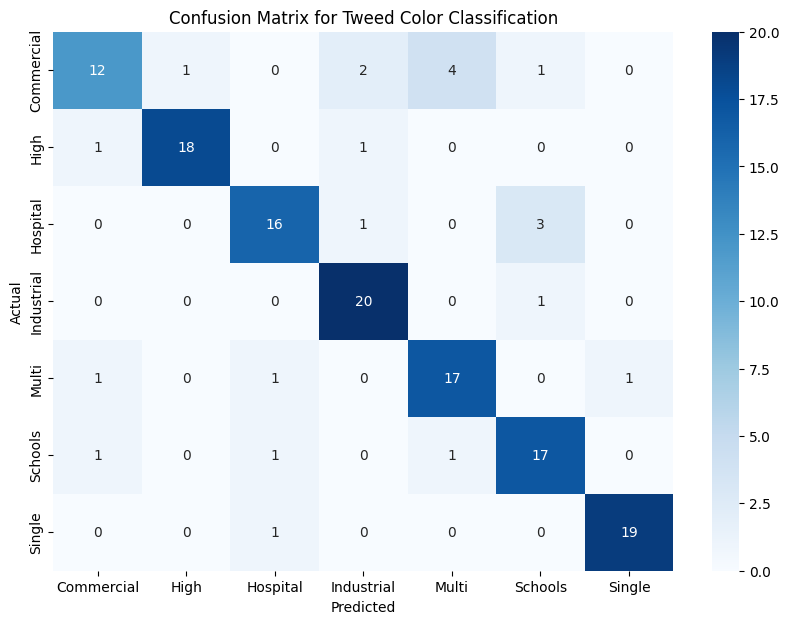

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Your confusion matrix
conf_matrix = np.array([[12, 1, 0, 2, 4, 1, 0],
                       [ 1, 18, 0, 1, 0, 0, 0],
                       [ 0, 0, 16, 1, 0, 3, 0],
                       [ 0, 0, 0, 20, 0, 1, 0],
                       [ 1, 0, 1, 0, 17, 0, 1],
                       [ 1, 0, 1, 0, 1, 17, 0],
                       [ 0, 0, 1, 0, 0, 0, 19]])

# Tweed color labels
labels = ['Commercial', 'High', 'Hospital', 'Industrial', 'Multi', 'Schools', 'Single']

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Tweed Color Classification')
plt.show()

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import logging
import hashlib
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split

# -----------------------------------------------------------------------------
# Enable mixed precision and set seeds for reproducibility
# -----------------------------------------------------------------------------
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# -----------------------------------------------------------------------------
# Configure logging
# -----------------------------------------------------------------------------
logging.basicConfig(
    filename='model_training.log',
    level=logging.INFO,
    format='%(asctime)s:%(levelname)s:%(message)s'
)

# -----------------------------------------------------------------------------
# Verify GPU availability
# -----------------------------------------------------------------------------
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs Available:", gpus)
    logging.info(f"GPUs Available: {gpus}")
else:
    print("No GPU found. Please ensure TensorFlow is configured properly.")
    logging.warning("No GPU found. Using CPU for training.")

# -----------------------------------------------------------------------------
# PARAMETERS & DIRECTORIES
# -----------------------------------------------------------------------------
img_size = (512, 512)  # For training images
batch_size = 32

# Adjust these as needed
existing_train_dir = '/content/drive/MyDrive/Madhu RA Work Folder/newdata'
new_data_dir = '/content/drive/MyDrive/RA Satellite Imagery Work/Abduls RA Work Folder/SAT_Images/Phase 2'

# Directory where we'll save the final SavedModel (do not use .keras or .h5 extension)
saved_model_dir = '/content/drive/MyDrive/Madhu RA Work Folder/Densenet201_Feb_newdata_SavedModel'

# -----------------------------------------------------------------------------
# HELPER FUNCTION: Display random images from each class (for inspection)
# -----------------------------------------------------------------------------
def display_random_images(base_dir, class_names, num_images_to_display=5):
    """
    Display a few random images from each class.
    :param base_dir: Directory containing subdirectories (one per class)
    :param class_names: List of subdirectory names (classes)
    :param num_images_to_display: Number of images to display per class
    """
    for class_name in class_names:
        class_path = os.path.join(base_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        images = os.listdir(class_path)
        if len(images) > num_images_to_display:
            images = random.sample(images, num_images_to_display)
        print(f'Class: {class_name}')
        plt.figure(figsize=(15, 3))
        for i, image_name in enumerate(images):
            image_path = os.path.join(class_path, image_name)
            image = load_img(image_path, target_size=(224, 224))
            image_array = img_to_array(image)
            plt.subplot(1, num_images_to_display, i + 1)
            plt.imshow(image_array.astype('uint8'))
            plt.title(f"{class_name[:10]}...")
            plt.axis('off')
        plt.show()

# -----------------------------------------------------------------------------
# FUNCTIONS FOR DATA COLLECTION & PREPROCESSING
# -----------------------------------------------------------------------------
def get_class_names(directories):
    class_names = set()
    for directory in directories:
        if not os.path.isdir(directory):
            logging.warning(f"Directory '{directory}' does not exist. Skipping.")
            continue
        classes_in_dir = [item for item in os.listdir(directory) if os.path.isdir(os.path.join(directory, item))]
        print(f"Classes in '{directory}': {classes_in_dir}")
        logging.info(f"Classes in '{directory}': {classes_in_dir}")
        class_names.update(classes_in_dir)
    class_names = sorted(list(class_names))
    print("Combined Classes from Training Directories:", class_names)
    logging.info(f"Combined Classes from Training Directories: {class_names}")
    return class_names

def collect_data_paths(data_directories, class_names):
    image_paths = []
    labels = []
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}
    image_hashes = set()
    duplicate_count = 0

    for data_directory in data_directories:
        if not os.path.isdir(data_directory):
            logging.warning(f"Data directory '{data_directory}' does not exist. Skipping.")
            continue
        for class_name in class_names:
            folder_path = os.path.join(data_directory, class_name)
            if not os.path.isdir(folder_path):
                logging.warning(f"Class directory '{folder_path}' does not exist in '{data_directory}'. Skipping.")
                continue
            for img_file in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_file)
                if img_file.lower().endswith(('.tif', '.tiff', '.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                    try:
                        with open(img_path, 'rb') as f:
                            img_hash = hashlib.md5(f.read()).hexdigest()
                        if img_hash in image_hashes:
                            duplicate_count += 1
                            logging.info(f"Duplicate image found and skipped: {img_path}")
                            continue
                        image_hashes.add(img_hash)
                        image_paths.append(img_path)
                        labels.append(class_indices[class_name])
                    except Exception as e:
                        logging.error(f"Error processing image {img_path}: {e}")
    print(f"Total duplicates found and removed: {duplicate_count}")
    logging.info(f"Total duplicates found and removed: {duplicate_count}")
    return image_paths, labels

def load_image_with_pil(filename):
    filename = filename.decode('utf-8')
    try:
        image = Image.open(filename).convert('RGB')
        image = image.resize(img_size)
        image = np.array(image) / 255.0
        return image.astype(np.float32)
    except Exception as e:
        logging.error(f"Error loading image {filename}: {e}")
        return np.zeros((*img_size, 3), dtype=np.float32)

def parse_function(filename, label):
    image = tf.numpy_function(load_image_with_pil, [filename], tf.float32)
    image.set_shape([img_size[0], img_size[1], 3])
    return image, label

# Data augmentation layers
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

def create_dataset(image_paths, labels, training=True):
    labels = np.array(labels)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        dataset = dataset.shuffle(buffer_size=1024)
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y),
                              num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# -----------------------------------------------------------------------------
# MODEL BUILDING
# -----------------------------------------------------------------------------
def build_model(num_classes):
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
    # Freeze first 500 layers
    for layer in base_model.layers[:500]:
        layer.trainable = False
    for layer in base_model.layers[500:]:
        layer.trainable = True

    inputs = Input(shape=(img_size[0], img_size[1], 3))
    x = base_model(inputs, training=True)
    x = GlobalAveragePooling2D()(x)
    x = Dense(768, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    # Output uses float32
    outputs = Dense(num_classes, activation='softmax', dtype='float32')(x)

    model = Model(inputs, outputs)
    optimizer = Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

def print_class_counts(labels, class_names, dataset_name):
    counts = Counter(labels)
    print(f"\nDataset: {dataset_name}")
    logging.info(f"Dataset: {dataset_name}")
    for class_index, class_name in enumerate(class_names):
        count = counts.get(class_index, 0)
        print(f"Class: {class_name}, Number of images: {count}")
        logging.info(f"Class: {class_name}, Number of images: {count}")
    print("\n")

def balance_dataset(image_paths, labels):
    random.seed(42)
    class_to_images = defaultdict(list)
    for img_path, label in zip(image_paths, labels):
        class_to_images[label].append(img_path)
    min_count = min(len(img_list) for img_list in class_to_images.values())
    print(f"Balancing classes to have {min_count} images each.")
    logging.info(f"Balancing classes to have {min_count} images each.")
    balanced_image_paths = []
    balanced_labels = []
    for label, img_list in class_to_images.items():
        sampled_imgs = random.sample(img_list, min_count)
        balanced_image_paths.extend(sampled_imgs)
        balanced_labels.extend([label] * min_count)
    return balanced_image_paths, balanced_labels

def shuffle_data(paths, labels):
    combined = list(zip(paths, labels))
    random.shuffle(combined)
    paths[:], labels[:] = zip(*combined)
    return list(paths), list(labels)

# -----------------------------------------------------------------------------
# TRAINING & EVALUATION FUNCTION
# -----------------------------------------------------------------------------
def train_and_evaluate(train_dirs, img_size=(512, 512), batch_size=32, epochs=4):
    class_names = get_class_names(train_dirs)

    # Collect image paths and labels, then balance the dataset
    all_image_paths, all_labels = collect_data_paths(train_dirs, class_names)
    all_image_paths, all_labels = balance_dataset(all_image_paths, all_labels)

    # Split data into training, validation, and testing sets
    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        all_image_paths, all_labels, test_size=0.2, stratify=all_labels, random_state=42
    )
    print(f"Training images: {len(train_paths)}")
    print(f"Temp images (for validation/testing): {len(temp_paths)}")
    logging.info(f"Training images: {len(train_paths)}")
    logging.info(f"Temp images (for validation/testing): {len(temp_paths)}")

    val_paths, test_paths, val_labels, test_labels = train_test_split(
        temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
    )
    print(f"Validation images: {len(val_paths)}")
    print(f"Test images: {len(test_paths)}")
    logging.info(f"Validation images: {len(val_paths)}")
    logging.info(f"Test images: {len(test_paths)}")

    print_class_counts(train_labels, class_names, "Training set")
    print_class_counts(val_labels, class_names, "Validation set")
    print_class_counts(test_labels, class_names, "Test set")

    train_dataset = create_dataset(train_paths, train_labels, training=True)
    val_dataset = create_dataset(val_paths, val_labels, training=False)
    test_dataset = create_dataset(test_paths, test_labels, training=False)

    num_classes = len(class_names)
    print(f"Training with classes: {class_names}")
    logging.info(f"Training with classes: {class_names}")
    print(f"Total images collected: {len(all_image_paths)}")
    logging.info(f"Total images collected: {len(all_image_paths)}")

    # Build and train the model
    model = build_model(num_classes)
    logging.info("Model built and compiled successfully.")

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        callbacks=[early_stopping, reduce_lr]
    )
    logging.info("Model training completed.")

    # -----------------------------------------------------------------------------
    # SAVE IN SAVEDMODEL FORMAT (Recommended)
    # -----------------------------------------------------------------------------
    model.save(saved_model_dir)  # Removed save_format argument per Keras 3 deprecation
    print(f"Model saved in SavedModel format at: {saved_model_dir}")
    logging.info(f"Model saved in SavedModel format at: {saved_model_dir}")

    # Optionally: Evaluate on the test set
    plot_training_history(history)
    logging.info("Training history plotted.")

    test_loss, test_accuracy = model.evaluate(test_dataset)
    print(f"Test Accuracy: {test_accuracy:.4%}")
    logging.info(f"Test Accuracy: {test_accuracy:.4%}")

    y_true = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)
    y_pred_probs = model.predict(test_dataset)
    y_pred = np.argmax(y_pred_probs, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)
    logging.info(f"Confusion Matrix:\n{cm}")

    cr = classification_report(y_true, y_pred, labels=range(num_classes), target_names=class_names, zero_division=0)
    print("Classification Report:\n", cr)
    logging.info(f"Classification Report:\n{cr}")

    return model, saved_model_dir, class_names

# -----------------------------------------------------------------------------
# FUNCTION TO PLOT PREDICTIONS ON A BATCH OF VALIDATION IMAGES
# -----------------------------------------------------------------------------
def plot_images_with_predictions(generator, model, class_labels, num_images=10):
    images, labels = next(generator)
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = labels.astype(int)
    plt.figure(figsize=(20, 10))
    for i in range(min(num_images, len(images))):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Pred: {class_labels[predicted_labels[i]]}\nTrue: {class_labels[true_labels[i]]}")
        plt.axis('off')
    plt.show()

# -----------------------------------------------------------------------------
# MAIN EXECUTION
# -----------------------------------------------------------------------------
if __name__ == "__main__":
    # 1) Display some images from existing_train_dir
    sample_class_names = get_class_names([existing_train_dir])
    print("\nDisplaying sample images from each class (before training):")
    display_random_images(existing_train_dir, sample_class_names, num_images_to_display=5)

    # 2) Train and evaluate the model using data from new_data_dir
    train_dirs = [new_data_dir]
    print("\nTraining model with combined training data:")
    logging.info("Starting model training with combined training data.")
    trained_model, saved_model_dir, class_names = train_and_evaluate(
        train_dirs,
        img_size=img_size,
        batch_size=batch_size,
        epochs=4
    )

    print(f"\nFinal model saved in SavedModel format at: {saved_model_dir}")

    # -----------------------------------------------------------------------------
    # 3) SET UP VALIDATION GENERATOR (224x224) FOR PREDICTION VISUALIZATION
    # -----------------------------------------------------------------------------
    target_height, target_width = 224, 224
    validation_datagen = ImageDataGenerator(rescale=1.0/255.0)
    val_path = existing_train_dir  # or another directory for validation data

    validation_generator = validation_datagen.flow_from_directory(
        val_path,
        target_size=(target_height, target_width),
        batch_size=32,
        class_mode='sparse',
        shuffle=False
    )

    # 4) LOAD THE SAVED MODEL FROM SavedModel FORMAT
    loaded_model = tf.keras.models.load_model(saved_model_dir)
    print("Model loaded from SavedModel format:", saved_model_dir)

    # 5) Get class labels from the generator
    class_indices = validation_generator.class_indices
    index_to_class = {v: k for k, v in class_indices.items()}
    class_labels = [index_to_class[i] for i in range(len(index_to_class))]

    # 6) Plot predictions on a batch of validation images
    plot_images_with_predictions(validation_generator, loaded_model, class_labels, num_images=10)

    # 7) Evaluate on the validation set
    val_loss, val_accuracy = loaded_model.evaluate(validation_generator)
    print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Input, Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
import logging
import hashlib
from collections import Counter, defaultdict
from sklearn.model_selection import train_test_split

# -----------------------------------------------------------------------------
# Enable mixed precision and set seeds for reproducibility
# -----------------------------------------------------------------------------
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# -----------------------------------------------------------------------------
# Configure logging
# -----------------------------------------------------------------------------
logging.basicConfig(
    filename='model_training.log',
    level=logging.INFO,
    format='%(asctime)s:%(levelname)s:%(message)s'
)

# -----------------------------------------------------------------------------
# Verify GPU availability
# -----------------------------------------------------------------------------
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("GPUs Available:", gpus)
    logging.info(f"GPUs Available: {gpus}")
else:
    print("No GPU found. Please ensure TensorFlow is configured properly.")
    logging.warning("No GPU found. Using CPU for training.")

# -----------------------------------------------------------------------------
# PARAMETERS & DIRECTORIES
# -----------------------------------------------------------------------------
img_size = (512, 512)  # For training images
batch_size = 32

# Adjust these paths as needed
existing_train_dir = '/content/drive/MyDrive/Madhu RA Work Folder/newdata'
new_data_dir = '/content/drive/MyDrive/RA Satellite Imagery Work/Abduls RA Work Folder/SAT_Images/Phase 2'

# Directory where we'll save the final SavedModel.
# Note: The path does NOT end with .h5 or .keras.
saved_model_dir = '/content/drive/MyDrive/Madhu RA Work Folder/Densenet201_Feb_newdata_SavedModel'

# -----------------------------------------------------------------------------
# HELPER FUNCTION: Display random images from each class (for inspection)
# -----------------------------------------------------------------------------
def display_random_images(base_dir, class_names, num_images_to_display=5):
    for class_name in class_names:
        class_path = os.path.join(base_dir, class_name)
        if not os.path.isdir(class_path):
            continue
        images = os.listdir(class_path)
        if len(images) > num_images_to_display:
            images = random.sample(images, num_images_to_display)
        print(f'Class: {class_name}')
        plt.figure(figsize=(15, 3))
        for i, image_name in enumerate(images):
            image_path = os.path.join(class_path, image_name)
            image = load_img(image_path, target_size=(224, 224))
            image_array = img_to_array(image)
            plt.subplot(1, num_images_to_display, i + 1)
            plt.imshow(image_array.astype('uint8'))
            plt.title(f"{class_name[:10]}...")
            plt.axis('off')
        plt.show()

# -----------------------------------------------------------------------------
# FUNCTIONS FOR DATA COLLECTION & PREPROCESSING
# -----------------------------------------------------------------------------
def get_class_names(directories):
    class_names = set()
    for directory in directories:
        if not os.path.isdir(directory):
            logging.warning(f"Directory '{directory}' does not exist. Skipping.")
            continue
        classes_in_dir = [item for item in os.listdir(directory) if os.path.isdir(os.path.join(directory, item))]
        print(f"Classes in '{directory}': {classes_in_dir}")
        logging.info(f"Classes in '{directory}': {classes_in_dir}")
        class_names.update(classes_in_dir)
    class_names = sorted(list(class_names))
    print("Combined Classes from Training Directories:", class_names)
    logging.info(f"Combined Classes from Training Directories: {class_names}")
    return class_names

def collect_data_paths(data_directories, class_names):
    image_paths = []
    labels = []
    class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}
    image_hashes = set()
    duplicate_count = 0

    for data_directory in data_directories:
        if not os.path.isdir(data_directory):
            logging.warning(f"Data directory '{data_directory}' does not exist. Skipping.")
            continue
        for class_name in class_names:
            folder_path = os.path.join(data_directory, class_name)
            if not os.path.isdir(folder_path):
                logging.warning(f"Class directory '{folder_path}' does not exist in '{data_directory}'. Skipping.")
                continue
            for img_file in os.listdir(folder_path):
                img_path = os.path.join(folder_path, img_file)
                if img_file.lower().endswith(('.tif', '.tiff', '.jpg', '.jpeg', '.png', '.bmp', '.gif')):
                    try:
                        with open(img_path, 'rb') as f:
                            img_hash = hashlib.md5(f.read()).hexdigest()
                        if img_hash in image_hashes:
                            duplicate_count += 1
                            logging.info(f"Duplicate image found and skipped: {img_path}")
                            continue
                        image_hashes.add(img_hash)
                        image_paths.append(img_path)
                        labels.append(class_indices[class_name])
                    except Exception as e:
                        logging.error(f"Error processing image {img_path}: {e}")
    print(f"Total duplicates found and removed: {duplicate_count}")
    logging.info(f"Total duplicates found and removed: {duplicate_count}")
    return image_paths, labels

def load_image_with_pil(filename):
    filename = filename.decode('utf-8')
    try:
        image = Image.open(filename).convert('RGB')
        image = image.resize(img_size)
        image = np.array(image) / 255.0
        return image.astype(np.float32)
    except Exception as e:
        logging.error(f"Error loading image {filename}: {e}")
        return np.zeros((*img_size, 3), dtype=np.float32)

def parse_function(filename, label):
    image = tf.numpy_function(load_image_with_pil, [filename], tf.float32)
    image.set_shape([img_size[0], img_size[1], 3])
    return image, label

data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
])

def create_dataset(image_paths, labels, training=True):
    labels = np.array(labels)
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    if training:
        dataset = dataset.shuffle(buffer_size=1024)
        dataset = dataset.map(lambda x, y: (data_augmentation(x, training=True), y),
                              num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

# -----------------------------------------------------------------------------
# MODEL BUILDING
# -----------------------------------------------------------------------------
def build_model(num_classes):
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
    for layer in base_model.layers[:500]:
        layer.trainable = False
    for layer in base_model.layers[500:]:
        layer.trainable = True

    inputs = Input(shape=(img_size[0], img_size[1], 3))
    x = base_model(inputs, training=True)
    x = GlobalAveragePooling2D()(x)
    x = Dense(768, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax', dtype='float32')(x)

    model = Model(inputs, outputs)
    optimizer = Adam(learning_rate=1e-4)
    model.compile(optimizer=optimizer,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def plot_training_history(history):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

def print_class_counts(labels, class_names, dataset_name):
    counts = Counter(labels)
    print(f"\nDataset: {dataset_name}")
    logging.info(f"Dataset: {dataset_name}")
    for class_index, class_name in enumerate(class_names):
        count = counts.get(class_index, 0)
        print(f"Class: {class_name}, Number of images: {count}")
        logging.info(f"Class: {class_name}, Number of images: {count}")
    print("\n")

def balance_dataset(image_paths, labels):
    random.seed(42)
    class_to_images = defaultdict(list)
    for img_path, label in zip(image_paths, labels):
        class_to_images[label].append(img_path)
    min_count = min(len(img_list) for img_list in class_to_images.values())
    print(f"Balancing classes to have {min_count} images each.")
    logging.info(f"Balancing classes to have {min_count} images each.")
    balanced_image_paths = []
    balanced_labels = []
    for label, img_list in class_to_images.items():
        sampled_imgs = random.sample(img_list, min_count)
        balanced_image_paths.extend(sampled_imgs)
        balanced_labels.extend([label] * min_count)
    return balanced_image_paths, balanced_labels

def shuffle_data(paths, labels):
    combined = list(zip(paths, labels))
    random.shuffle(combined)
    paths[:], labels[:] = zip(*combined)
    return list(paths), list(labels)

# -----------------------------------------------------------------------------
# TRAINING & EVALUATION FUNCTION
# -----------------------------------------------------------------------------
def train_and_evaluate(train_dirs, img_size=(512, 512), batch_size=32, epochs=4):
    class_names = get_class_names(train_dirs)
    all_image_paths, all_labels = collect_data_paths(train_dirs, class_names)
    all_image_paths, all_labels = balance_dataset(all_image_paths, all_labels)

    train_paths, temp_paths, train_labels, temp_labels = train_test_split(
        all_image_paths, all_labels, test_size=0.2, stratify=all_labels, random_state=42
    )
    print(f"Training images: {len(train_paths)}")
    print(f"Temp images (for validation/testing): {len(temp_paths)}")
    logging.info(f"Training images: {len(train_paths)}")
    logging.info(f"Temp images (for validation/testing): {len(temp_paths)}")

    val_paths, test_paths, val_labels, test_labels = train_test_split(
        temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42
    )
    print(f"Validation images: {len(val_paths)}")
    print(f"Test images: {len(test_paths)}")
    logging.info(f"Validation images: {len(val_paths)}")
    logging.info(f"Test images: {len(test_paths)}")

    print_class_counts(train_labels, class_names, "Training set")
    print_class_counts(val_labels, class_names, "Validation set")
    print_class_counts(test_labels, class_names, "Test set")

    train_dataset = create_dataset(train_paths, train_labels, training=True)
    val_dataset = create_dataset(val_paths, val_labels, training=False)
    test_dataset = create_dataset(test_paths, test_labels, training=False)

    num_classes = len(class_names)
    print(f"Training with classes: {class_names}")
    logging.info(f"Training with classes: {class_names}")
    print(f"Total images collected: {len(all_image_paths)}")
    logging.info(f"Total images collected: {len(all_image_paths)}")

    model = build_model(num_classes)
    logging.info("Model built and compiled successfully.")

    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=1e-6)

    history = model.fit(
        train_dataset,
        epochs=epochs,
        validation_data=val_dataset,
        callbacks=[early_stopping, reduce_lr]
    )
    logging.info("Model training completed.")

    # Save the model in SavedModel format (do not use save_format argument)
    model.save(saved_model_dir)
    print(f"Model saved in SavedModel format at: {saved_model_dir}")
    logging.info(f"Model saved in SavedModel format at: {saved_model_dir}")

    plot_training_history(history)
    logging.info("Training history plotted.")

    test_loss, test_accuracy = model.evaluate(test_dataset)
    print(f"Test Accuracy: {test_accuracy:.4%}")
    logging.info(f"Test Accuracy: {test_accuracy:.4%}")

    y_true = np.concatenate([y.numpy() for x, y in test_dataset], axis=0)
    y_pred_probs = model.predict(test_dataset)
    y_pred = np.argmax(y_pred_probs, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    print("Confusion Matrix:\n", cm)
    logging.info(f"Confusion Matrix:\n{cm}")

    cr = classification_report(y_true, y_pred, labels=range(num_classes), target_names=class_names, zero_division=0)
    print("Classification Report:\n", cr)
    logging.info(f"Classification Report:\n{cr}")

    return model, saved_model_dir, class_names

# -----------------------------------------------------------------------------
# FUNCTION TO PLOT PREDICTIONS ON A BATCH OF VALIDATION IMAGES
# -----------------------------------------------------------------------------
def plot_images_with_predictions(generator, model, class_labels, num_images=10):
    images, labels = next(generator)
    predictions = model.predict(images)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = labels.astype(int)
    plt.figure(figsize=(20, 10))
    for i in range(min(num_images, len(images))):
        plt.subplot(2, 3, i + 1)
        plt.imshow(images[i])
        plt.title(f"Pred: {class_labels[predicted_labels[i]]}\nTrue: {class_labels[true_labels[i]]}")
        plt.axis('off')
    plt.show()

# -----------------------------------------------------------------------------
# MAIN EXECUTION
# -----------------------------------------------------------------------------
if __name__ == "__main__":
    # 1) Display some images from existing_train_dir
    sample_class_names = get_class_names([existing_train_dir])
    print("\nDisplaying sample images from each class (before training):")
    display_random_images(existing_train_dir, sample_class_names, num_images_to_display=5)

    # 2) Train and evaluate the model using data from new_data_dir
    train_dirs = [new_data_dir]
    print("\nTraining model with combined training data:")
    logging.info("Starting model training with combined training data.")
    trained_model, saved_model_dir, class_names = train_and_evaluate(
        train_dirs,
        img_size=img_size,
        batch_size=batch_size,
        epochs=4
    )

    print(f"\nFinal model saved in SavedModel format at: {saved_model_dir}")

    # 3) SET UP VALIDATION GENERATOR (224x224) FOR PREDICTION VISUALIZATION
    target_height, target_width = 224, 224
    validation_datagen = ImageDataGenerator(rescale=1.0/255.0)
    val_path = existing_train_dir  # or another directory for validation data

    validation_generator = validation_datagen.flow_from_directory(
        val_path,
        target_size=(target_height, target_width),
        batch_size=32,
        class_mode='sparse',
        shuffle=False
    )

    # 4) LOAD THE SAVED MODEL FROM SavedModel FORMAT
    loaded_model = tf.keras.models.load_model(saved_model_dir)
    print("Model loaded from SavedModel format:", saved_model_dir)

    # 5) Get class labels from the generator
    class_indices = validation_generator.class_indices
    index_to_class = {v: k for k, v in class_indices.items()}
    class_labels = [index_to_class[i] for i in range(len(index_to_class))]

    # 6) Plot predictions on a batch of validation images
    plot_images_with_predictions(validation_generator, loaded_model, class_labels, num_images=10)

    # 7) Evaluate on the validation set
    val_loss, val_accuracy = loaded_model.evaluate(validation_generator)
    print(f'Validation Accuracy: {val_accuracy * 100:.2f}%')


Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    """
    Generates a Grad-CAM heatmap for a given image.
    """
    # Create a model that maps the input image to the activations of the last conv layer and the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Record operations for automatic differentiation
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute gradients of the predicted class with respect to the output feature map
    grads = tape.gradient(class_channel, conv_outputs)
    # Compute the mean intensity of the gradients for each feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply each channel in the feature map array by "how important this channel is"
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def display_gradcam(image_path, model, last_conv_layer_name, pred_index=None, alpha=0.4):
    """
    Loads an image, computes the Grad-CAM heatmap, and overlays it on the original image.
    """
    # Load and preprocess the image
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    # Generate the heatmap
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index)

    # Rescale heatmap to a range of 0-255 for display
    heatmap = np.uint8(255 * heatmap)

    # Use a colormap to colorize the heatmap
    jet = plt.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.size[0], img.size[1]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on the original image
    superimposed_img = jet_heatmap * alpha + img_array[0] * 255
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Display the result
    plt.imshow(superimposed_img)
    plt.axis('off')
    plt.title("Grad-CAM Overlay")
    plt.show()

# Example usage:
# Replace 'conv5_block32_concat' with the name of the last conv layer in DenseNet201 (check model.summary())
last_conv_layer_name = 'conv5_block32_concat'  # Change if necessary
sample_image_path = '/content/drive/MyDrive/RA Satellite Imagery Work/Abduls RA Work Folder/SAT_Images/Phase 2/High/25.794890_-80.187493_FL_HB_121.tif'
display_gradcam(sample_image_path, model, last_conv_layer_name)

NameError: name 'model' is not defined